In [4]:
import random

import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn
import tensorflow as tf
from tensorflow import keras as k
import sounddevice as sd
import uuid
import json
import math
from time import sleep
from PIL import Image


In [11]:
def record(record_number = 10, count = 0, fs = 44100, duration = 2, meta_data_file = 'data/sound/meta.txt', label = 'one',mode='w'):

    meta_data = {}

    f = open(meta_data_file, mode=mode)

    #collect n number of samples
    for i in range (record_number):
        print ("Recording in 1...")
        sleep(1)
        print ("Recording...")
        f_name = str(count)

        meta_data['id'] = uuid.uuid4().hex
        meta_data['sampling_rate'] = fs
        meta_data['duration'] = duration
        meta_data['file_name'] = str(count) + '.npy'
        meta_data['label'] = label

        #sample data from mic
        val = sd.rec(frames=fs*duration, samplerate=fs, channels=1)
        sd.wait()

        # transform obj to string
        meta_json_data = json.dumps(meta_data)
        f.write(meta_json_data + '\n')


        np.save('data/sound/'+f_name+'.npy',val)

        count += 1
        print ("Recording...Done")
        print('meta info:', meta_data)

    f.close()
    print ("Recording...Done")

In [13]:
record(record_number=100,label='right')

Recording in 1...
Recording...
Recording...Done
meta info: {'id': 'eca6fd87f8af4622a19bfc743f2495e3', 'sampling_rate': 44100, 'duration': 2, 'file_name': '0.npy', 'label': 'right'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '53b5af8db77b4e02b95e1dfbf745744b', 'sampling_rate': 44100, 'duration': 2, 'file_name': '1.npy', 'label': 'right'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': 'fc4975d66d434540aaf2d0881c9cdc68', 'sampling_rate': 44100, 'duration': 2, 'file_name': '2.npy', 'label': 'right'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': 'af06ce1df9ef4507b6946d35825eeb52', 'sampling_rate': 44100, 'duration': 2, 'file_name': '3.npy', 'label': 'right'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '2d8c8c7491104c73a3554ca2d8077131', 'sampling_rate': 44100, 'duration': 2, 'file_name': '4.npy', 'label': 'right'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '6790d33af0b0441b914f9a81c184

In [14]:
record(record_number=100,count=100,mode='a',label='left')

Recording in 1...
Recording...
Recording...Done
meta info: {'id': '38e839231016409196e05101a27250b2', 'sampling_rate': 44100, 'duration': 2, 'file_name': '100.npy', 'label': 'left'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '156b152a8f964032ac3808738bf640b1', 'sampling_rate': 44100, 'duration': 2, 'file_name': '101.npy', 'label': 'left'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '0804fca96b98490db253a49467b15de9', 'sampling_rate': 44100, 'duration': 2, 'file_name': '102.npy', 'label': 'left'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '6df740e0aadf43e489426e52945c8fd7', 'sampling_rate': 44100, 'duration': 2, 'file_name': '103.npy', 'label': 'left'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': 'dc44c8f1d633423096c886ce6703edfd', 'sampling_rate': 44100, 'duration': 2, 'file_name': '104.npy', 'label': 'left'}
Recording in 1...
Recording...
Recording...Done
meta info: {'id': '61404116dca94d23913b4cb

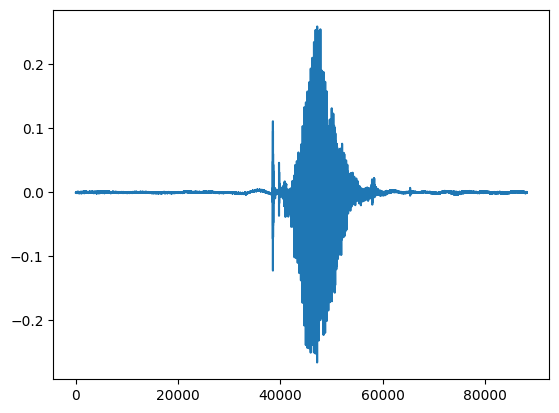

In [20]:
val = np.load('data/sound/40.npy')
plt.plot(val)